In [1]:
# Handling the file
import os 

# Storing some numpy features
import pickle

# Preprocess the text
from tensorflow.keras.preprocessing.text import Tokenizer 

# Importing various modules from TensorFlow Keras
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, Embedding, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Even out the whole text representation feature
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importing the numpy library as 'np'
import numpy as np 

# Importing the 'tqdm' library for creating progress bars in the user interface
from tqdm.notebook import tqdm 

In [20]:
# Define the Base and Working Directory
#Base Directory - where all the data is stored
#Working Directory - where all the data need to be saved
BASE_DIR = '/Users/aman/Desktop/Dissertation/Python Notebook/Datasets/Main Data'
WORKING_DIR = '/Users/aman/Desktop/Dissertation/Python Notebook/Datasets/RESNET'


LOADING FEATURES

In [3]:
# load features from pickle
with open(os.path.join(BASE_DIR, 'resnet_features.pkl'), 'rb') as f:
    features = pickle.load(f)
    

In [4]:
len(features)


76652

#Load the Captions Data


In [5]:
def load_cleaned_data(file_path):
    mapping = {}
    current_key = None
    current_captions = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespace
        if line:
            if line.endswith(':'):
                if current_key is not None:
                    mapping[current_key] = current_captions
                current_key = line[:-1]  # Remove the colon
                current_captions = []
            else:
                current_captions.append(line)

    if current_key is not None:
        mapping[current_key] = current_captions

    return mapping

# Specify the file path from which you want to load the data
file_path = os.path.join(BASE_DIR, 'mapping.txt')

# Call the function to load the data
mapping = load_cleaned_data(file_path)

# Now, loaded_mapping will contain the dictionary loaded from the file


In [6]:
len(mapping)


76652

In [7]:
# Create an empty list to store all captions
all_captions = []
# Iterate through each key in the mapping dictionary
for key in mapping:
    # Iterate through each caption in the list corresponding to the current key
    for caption in mapping[key]:
        # Append the caption to the all_captions list
        all_captions.append(caption)
        

In [8]:
len(all_captions)


76652

In [9]:
# Creates a Tokenizer object for preprocessing and tokenizing text data.
tokenizer = Tokenizer()

# Fits the Tokenizer onto a list of all captions to build a vocabulary.
# This step assigns a unique integer to each word in the captions.
tokenizer.fit_on_texts(all_captions)

# Determines the size of the vocabulary by counting unique words in the captions
# and adding 1 to account for the special padding token (usually denoted by 0).
vocab_size = len(tokenizer.word_index) + 1


In [10]:
vocab_size


15100

In [11]:
# Access the vocabulary (word to index mapping) created by the Tokenizer
word_index = tokenizer.word_index

# Convert the word_index dictionary to a list of words
vocabulary_words = list(word_index.keys())

# Print the vocabulary words
print(vocabulary_words)

['startseq', 'endseq', 'photographed', 'and', 'the', 'view', 'by', 'of', 'trust', 'record', 'digitisation', 'funded', 'pilgrim', 'circa', 'number', 'october', 'photograph', 'august', 'june', 'waltzer', 'lorry', 'registration', 'september', 'may', 'general', 'july', 'taken', 'april', 'gallopers', 'at', 'whole', 'box', 'engine', 'ark', 'negative', 'with', 'tractor', 'on', 'for', 'wheel', 'no', 'circus', 'march', 'front', 'see', 'in', 'up', 'dodgem', 'side', 'brothers', 'john', 'fair', 'truck', 'bradley', 'foden', 'also', 'dg', 'only', 'reference', 'collins', 'burrell', 'scammell', 'twist', 'miami', 'details', 'building', 'date', 'tw', 'juvenile', 'detail', 'centre', 'mm', 'steam', 'night', 'framed', 'harry', 'show', 'site', 'thurstons', 'erf', 'wilsons', 'loads', 'scott', 'billy', 'pat', 'coaster', 'to', 'wagon', 'unidentified', 'leyland', 'hollands', 'atkinson', 'or', 'big', 'organ', 'is', 'living', 'location', 'yachts', 'swirl', 'train', 'car', 'octopus', 'rowlands', 'flat', 'aec', 'co

In [12]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length


189

Train Test Split

In [13]:
import random

# Generates a list of image IDs by extracting keys from a mapping.
image_ids = list(mapping.keys())

# Randomly shuffle the list of image IDs.
random.shuffle(image_ids)

# Calculates split points for dividing the shuffled image IDs into training, testing, and validation sets.
train_split = int(len(image_ids) * 0.7)
test_split = int(len(image_ids) * 0.9)

# Creates a training set containing the first 70% of shuffled image IDs.
train = image_ids[:train_split]

# Creates a testing set containing the next 20% of shuffled image IDs.
test = image_ids[train_split:test_split]

# Creates a validation set containing the last 10% of shuffled image IDs.
validation = image_ids[test_split:]


In [14]:
len(train)

53656

In [15]:
len(test)

15330

In [16]:
len(validation)

7666

Data Generator

In [17]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

In [18]:
#importing l2 Regularisation 
from keras.regularizers import l2

# Import the adam optimizer
from tensorflow.keras.optimizers import Adam

# Define the learning rate you want to use
learning_rate = 0.001
# Create the Adam optimizer with the specified learning rate
optimizer = Adam(lr=learning_rate)

# encoder model

# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(fe1)  #added L2 regularization

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(decoder1) #added L2 regularization
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model with the custom optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

MODEL TRAINING

In [17]:
# Import the EarlyStopping callback from Keras callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the best observed during training
)

# Initialize lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# train the model
epochs = 50
batch_size = 32
train_steps = len(train) // batch_size
val_steps = len(validation) // batch_size 

for epoch in range(epochs):
    # create data generator
    train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    validation_generator = data_generator(validation, mapping, features, tokenizer, max_length, vocab_size, batch_size)  

    # Modify the model.fit() call to include the EarlyStopping callback
    history = model.fit(
    train_generator,                        # Training data generator
    epochs=1,                               # Train for one epoch at a time
    steps_per_epoch=train_steps,            # Number of training steps per epoch
    validation_data=validation_generator,   # Validation data generator
    validation_steps=val_steps,             # Number of validation steps per epoch
    verbose=1,                              # Print training progress
    callbacks=[early_stopping]              # Include the EarlyStopping callback
)

    # Append training loss and accuracy to the respective lists
    train_losses.extend(history.history['loss'])
    train_accuracies.extend(history.history['accuracy'])

    # Get validation loss and accuracy
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    
    # Append validation loss and accuracy to the respective lists
    validation_losses.extend(val_loss)
    validation_accuracies.extend(val_accuracy)

    # Display the current epoch number, validation loss, and accuracy
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Validation Loss: {val_loss[-1]}, Validation Accuracy: {val_accuracy[-1]}")

1676/1676 [==============================] - 4054s 2s/step - loss: 4.3497 - accuracy: 0.3728 - val_loss: 3.5004 - val_accuracy: 0.4601
Epoch 1/50
Validation Loss: 3.5004053115844727, Validation Accuracy: 0.4600996971130371
1676/1676 [==============================] - 3780s 2s/step - loss: 3.2445 - accuracy: 0.4778 - val_loss: 3.1552 - val_accuracy: 0.5017
Epoch 2/50
Validation Loss: 3.1552164554595947, Validation Accuracy: 0.5016525983810425
1676/1676 [==============================] - 3108s 2s/step - loss: 2.9556 - accuracy: 0.5098 - val_loss: 2.9881 - val_accuracy: 0.5233
Epoch 3/50
Validation Loss: 2.9881186485290527, Validation Accuracy: 0.5233410596847534
1676/1676 [==============================] - 2454s 1s/step - loss: 2.7840 - accuracy: 0.5276 - val_loss: 2.9608 - val_accuracy: 0.5245
Epoch 4/50
Validation Loss: 2.960763931274414, Validation Accuracy: 0.5245238542556763
1676/1676 [==============================] - 2435s 1s/step - loss: 2.6627 - accuracy: 0.5400 - val_loss: 2.86

1676/1676 [==============================] - 2243s 1s/step - loss: 1.9301 - accuracy: 0.6328 - val_loss: 2.6535 - val_accuracy: 0.5968
Epoch 38/50
Validation Loss: 2.6535043716430664, Validation Accuracy: 0.5968406796455383
1676/1676 [==============================] - 2227s 1s/step - loss: 1.9247 - accuracy: 0.6335 - val_loss: 2.6504 - val_accuracy: 0.5969
Epoch 39/50
Validation Loss: 2.6504054069519043, Validation Accuracy: 0.5968517661094666
1676/1676 [==============================] - 2326s 1s/step - loss: 1.9182 - accuracy: 0.6345 - val_loss: 2.6370 - val_accuracy: 0.5987
Epoch 40/50
Validation Loss: 2.636991500854492, Validation Accuracy: 0.5986867547035217
1676/1676 [==============================] - 2252s 1s/step - loss: 1.9117 - accuracy: 0.6356 - val_loss: 2.6461 - val_accuracy: 0.5986
Epoch 41/50
Validation Loss: 2.6461446285247803, Validation Accuracy: 0.5985541343688965
1676/1676 [==============================] - 2221s 1s/step - loss: 1.9043 - accuracy: 0.6364 - val_loss: 

SAVING MODEL

In [18]:
# save the model
model.save(WORKING_DIR+'/05/resnet_e50_32_05')


INFO:tensorflow:Assets written to: /Users/aman/Desktop/Dissertation/Python Notebook/Datasets/ResNet/05/resnet_e50_32_05/assets


INFO:tensorflow:Assets written to: /Users/aman/Desktop/Dissertation/Python Notebook/Datasets/ResNet/05/resnet_e50_32_05/assets


In [19]:
# Save training history
history_dict = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'validation_accuracies':validation_accuracies,
    'validation_losses':validation_losses
}
pickle.dump(history_dict, open(os.path.join(WORKING_DIR, '05/resnet_e50_32_05_Hist.pkl'), 'wb'))


LOADING MODEL

In [21]:
from tensorflow.keras.models import load_model

 # Define the path to the saved model
model_path = WORKING_DIR +  '/Experiment 6/resnet_06'

 # Load the model
model = load_model(model_path)


2023-09-11 01:21:46.844945: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-09-11 01:21:46.967677: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-09-11 01:21:46.973728: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-09-11 01:21:46.985277: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-09-11 01:21:47.001868: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_sh

LOADING MODEL HISTORY

In [22]:
# Load training history from pickle file
with open(os.path.join(WORKING_DIR, 'Experiment 6/resnet_06_Hist.pkl'), 'rb') as f:
    loaded_history = pickle.load(f)

# You can now access the loaded history dictionary like this:
train_losses = loaded_history['train_losses']
train_accuracies = loaded_history['train_accuracies']
validation_accuracies = loaded_history['validation_accuracies']
validation_losses = loaded_history['validation_losses']


Visualisaiton of Train and Test

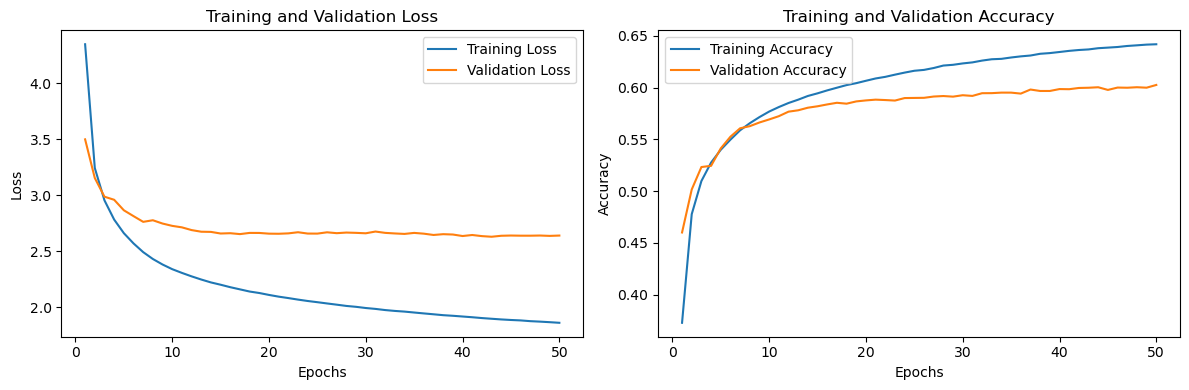

In [23]:
import matplotlib.pyplot as plt

# Mention the epochs number
epochs = 50

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

BLEU SCORE

In [24]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU scores
bleu_1_score = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2_score = corpus_bleu(actual, predicted, weights=(0.5, 0.5))

# Print BLEU scores
print("BLEU-1: %f" % bleu_1_score)
print("BLEU-2: %f" % bleu_2_score)


  0%|          | 0/15330 [00:00<?, ?it/s]

NameError: name 'predict_caption' is not defined


SAVING THE BLUE SCORE


In [38]:
# Save the BLEU scores to a text file
with open(os.path.join(WORKING_DIR,'05/resnet_e50_32_05_BLEU.txt'), 'w') as file:
    file.write(f"BLEU-1: {bleu_1_score}\n")
    file.write(f"BLEU-2: {bleu_2_score}\n")
    

LOADING THE BLUE SCORE


In [27]:
# Open the file for reading
with open(os.path.join(WORKING_DIR,'Experiment 6/resnet_06_BLEU.txt'), 'r') as file:
    # Read the content of the file line by line
    file_contents = file.readlines()

# Print the contents
for line in file_contents:
    print(line.strip())  # Use strip() to remove leading/trailing whitespace and newline characters
    

BLEU-1: 0.39431932866812314
BLEU-2: 0.2684280847084692


Visualize the Results

In [22]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "nfca_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        # Split the caption into words
        words = caption.split()
        
        # Remove the first and last word beacuse all the models were trained on the captions having two words
        # 'startseq'in the begging and two 'endseq' and at the end, doing so doesn't affect the model's output
        # training all the models again is very computational therefore this was done
        trimmed_caption = ' '.join(words[1:-1])
        
        print(trimmed_caption)
    
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')

    # Split the predicted caption into words
    pred_words = y_pred.split()

     # Remove the first and last word beacuse all the models were trained on the captions having two words
     # 'startseq'in the begging and two 'endseq' and at the end, doing so doesn't affect the model's output
     # training all the models is very computational therefore this was done
    trimmed_pred_caption = ' '.join(pred_words[1:])

    print(trimmed_pred_caption)

    plt.imshow(image)


---------------------Actual---------------------
startseq gerry cottles circus aerial act photographed endseq
--------------------Predicted--------------------
startseq nec circus horse act photographed endseq


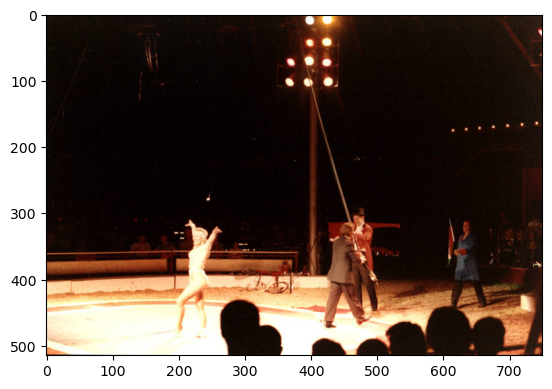

In [109]:
from PIL import Image

generate_caption("59081.jpg")